In [14]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


In [16]:
def add_noise(x, std=0.3):
    noise = torch.randn_like(x) * std
    noisy = x + noise
    return torch.clamp(noisy, 0., 1.)

In [17]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(-1, 1, 28, 28)


autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [18]:
epochs = 5
for epoch in range(epochs):
    loss_total = 0
    for images, _ in train_loader:
        noisy = add_noise(images)

        outputs = autoencoder(noisy)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_total += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_total/len(train_loader):.4f}")

Epoch 1/5, Loss: 0.0507
Epoch 2/5, Loss: 0.0253
Epoch 3/5, Loss: 0.0202
Epoch 4/5, Loss: 0.0173
Epoch 5/5, Loss: 0.0157


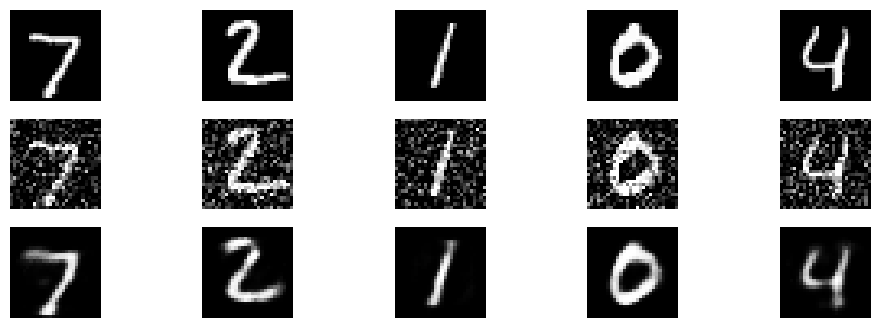

In [19]:
def mostrar(original, noisy, reconstructed, n=5):
    plt.figure(figsize=(12, 4))

    for i in range(n):
        # Original
        plt.subplot(3, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap="gray")
        plt.axis("off")

        # Con ruido
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].squeeze(), cmap="gray")
        plt.axis("off")

        # Reconstruida
        plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(reconstructed[i].detach().squeeze(), cmap="gray")
        plt.axis("off")

    plt.show()


# Obtener lote del test
images, _ = next(iter(test_loader))
noisy = add_noise(images)
reconstructed = autoencoder(noisy)

mostrar(images, noisy, reconstructed)